#Introduction

[Colab Notebook Link](https://colab.research.google.com/drive/1gbjQxNH2j50frE3guP1wGqM3CBeq6jN7?usp=sharing)

In this homework, my objective was to study image classification using Pytorch. Our goal this time is to asess how different convolution models handle classifying the MNIST Dataset, and then repeat the process with an augmented dataset to observe the results.

##Resources

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

https://pytorch.org/hub/pytorch_vision_resnet/

https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18


For learning about syntax specific to Pytorch visualization and relevant CNNs. This time, we use the forward function to have more control over activation functions and individual layers; the pre-trained ResNet we use on the other hand is a series of Convolution and batching layers with ReLU as an activation function. Like our previous neural networks, we choose ReLU as our activation function to prevent concerns with vanishing/exploding gradients and to introduce nonlinearity. We proceed to construct a CCN with several convolutional and max pooling layers that takes processed MNIST images and generates a feature map, which is then processed by dense layers to generate an appropriate classification from one of the 10 possible labels of numbers (0-9).

https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

For learning about the MNIST dataset.

Additional observations and relevant resources to verify them are cited in the comments as needed.

#Setup Requirements

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
RANDOM_SEED=29

In [ ]:
#Download MNIST Dataset and setup for Data Analysis
training_data = datasets.MNIST(root="./data", train=True, 
                               download=True, transform=ToTensor(),
)

test_data = datasets.MNIST(root="./data", train=False, 
                           download=True, transform=ToTensor(),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#Loading Data and Performing Exploratory Data Analysis

https://en.wikipedia.org/wiki/MNIST_database


The MNIST data set is already preprocessed for us on some level - an analysis shows that there is already a test/train split and that the values are normalized between 0 and 1 to be 28x28 grid images that are anti aliased and turned into gray scale color.  We review the dataset to ensure all of these preprocessings are already in place, and check to see if the dataset is balanced before splitting it into a train/val/test split and preparing it for use.

https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

Each instance is (image, target) where target is index of the target class.


In [ ]:
len(training_data)

60000

In [ ]:
len(test_data)

10000

In [ ]:
#We can observe here that the data has already been normalized
#by the makers of the dataset in range (0,1)
training_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
#count number of digits
counter_trd = [0] * 10
counter_ted = [0] * 10

for trd_instance in training_data:
  counter_trd[trd_instance[1]] = counter_trd[trd_instance[1]] +1
for ted_instance in test_data:
  counter_ted[ted_instance[1]] = counter_ted[ted_instance[1]] +1

In [ ]:
for i in range(0,10):
  print("Number of " , i+1,"s - Train: ",  counter_trd[i], " Test : ", counter_ted[i])

Number of  1 s - Train:  5923  Test :  980
Number of  2 s - Train:  6742  Test :  1135
Number of  3 s - Train:  5958  Test :  1032
Number of  4 s - Train:  6131  Test :  1010
Number of  5 s - Train:  5842  Test :  982
Number of  6 s - Train:  5421  Test :  892
Number of  7 s - Train:  5918  Test :  958
Number of  8 s - Train:  6265  Test :  1028
Number of  9 s - Train:  5851  Test :  974
Number of  10 s - Train:  5949  Test :  1009


In [ ]:
print("Training Data Stats:")
print("Mean: ", np.mean(counter_trd))
print("Standard Deviation: ", np.std(counter_trd))
print("Standard Deviation %: ", (np.std(counter_trd)/np.mean(counter_trd))*100)

print("Test Data Stats:")
print("Mean: ", np.mean(counter_ted))
print("Standard Deviation: ", np.std(counter_ted))
print("Standard Deviation %: ", (np.std(counter_ted)/np.mean(counter_ted))*100)

Training Data Stats:
Mean:  6000.0
Standard Deviation:  322.082908581005
Standard Deviation %:  5.368048476350083
Test Data Stats:
Mean:  1000.0
Standard Deviation:  59.196283667135724
Standard Deviation %:  5.919628366713573


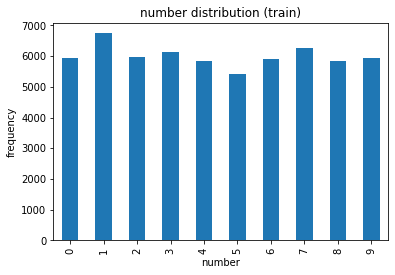

In [ ]:
df_nd = pd.DataFrame(counter_trd, columns=[''])
ax = df_nd.plot(kind='bar', title = "number distribution (train)")
ax.set_xlabel("number")
ax.set_ylabel("frequency")
ax.get_legend().remove()
plt.show()

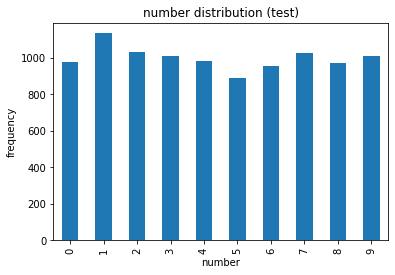

In [ ]:
df_nd = pd.DataFrame(counter_ted, columns=[''])
ax = df_nd.plot(kind='bar', title = "number distribution (test)")
ax.set_xlabel("number")
ax.set_ylabel("frequency")
ax.get_legend().remove()
plt.show()

The variance of the amount of individual numbers in the dataset is very
low, with both train and test datasets having standard deviation of
5% in terms of amounts of numbers. We can consider this dataset balanced.

#Visualizing the Appearance of MNIST Digits

In [ ]:
batch_size_v = 9

train_dataloader_v = DataLoader(training_data, batch_size=batch_size_v)
test_dataloader_v = DataLoader(test_data, batch_size=batch_size_v)

In [ ]:
#print(train_dataloader_v[0])

viewiter = iter(train_dataloader_v)
img, label = next(viewiter)

#parse = np.transpose(img,(2,3,1,0))
print(img)
print(img.size())
#plt.imshow(img)

img_np = img[0].numpy()
print(img_np.shape)

img_sq = img_np.squeeze()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

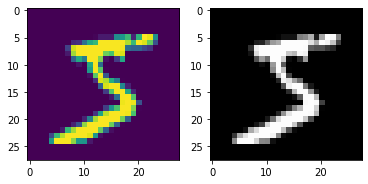

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(img_sq)
plt.subplot(1, 2, 2)
plt.imshow(img_sq, cmap=plt.cm.gray)
plt.show()


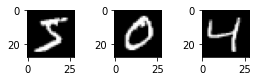

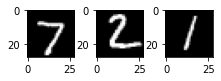

In [ ]:
viewiter = iter(train_dataloader_v)
img, label = next(viewiter)
for i in range (1,4):
  plt.subplot(4, 4, i)
  img_sq = img[i-1].numpy().squeeze()
  plt.imshow(img_sq, cmap=plt.cm.gray)
plt.show()

viewiter = iter(test_dataloader_v)
img, label = next(viewiter)
for i in range (1,4):
  plt.subplot(4, 5, i)
  img_sq = img[i-1].numpy().squeeze()
  plt.imshow(img_sq, cmap=plt.cm.gray)

plt.show()

#Train-Val Split

In [ ]:
type(training_data)

torchvision.datasets.mnist.MNIST

In [ ]:
#80% train 20% val
train_s_data, val_data = torch.utils.data.random_split(training_data, [48000, 12000])

#train_s_data, val_data,_test_data are our respecitve datasets.
#train_s_data to keep it distinct from the training data imported 

In [ ]:
print(len(train_s_data))
print(len(val_data))

48000
12000


In [ ]:
BATCH_SIZE=64

In [ ]:
train_dataloader = DataLoader(train_s_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

#Network Setup and Description



In [ ]:
#check what device we're using
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Dumoulin, Vincent, and Francesco Visin. "A guide to convolution arithmetic for deep learning." arXiv preprint arXiv:1603.07285 (2016).

https://medium.com/@aparnack/convolutional-neural-networks-part-1-2aeb17fc208c

Were consulted for convolution layer size calculations. The full explanation of the setup of the neural network is described in the comments 

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        #https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size,
        #stride=1, padding=0, dilation=1, groups=1, bias=True, 
        #padding_mode='zeros', device=None, dtype=None)
        #greyscale image, so only 1 input channel


        #we'll pad out first convolutional layer with zeros twice
        #on each row and column so that it becomes 32x32 image
        #and then apply a 4x4 convolution (kernel_size=4)
        self.conv1 = nn.Conv2d(1, 4, 4, padding = (2,2))
        #result should be a 6x6 feature map
        #visualizing this out we see a map of 36 squares that
        #can be reduced to 4 batches of 9.
        #So 2x2 max pooling should work.
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 16, 4)

        #testing  with various settings determined that 
        #2 convolution layers gave us meaningful improvement
        #in a reasonable amount of training time
        #restore additional layer(s) if you want to experiment with 
        #different training settings
        #self.conv3 = nn.Conv2d(16, 64, 2)

        #https://discuss.pytorch.org/t/how-to-transfer-tf-layers-dense-to-pytorch/45566
        #Dense layers are functionally equivalent to pytorch nn.Linear layers.

        #https://ai.stackexchange.com/questions/11342/how-to-chose-dense-layer-size
        #" For 20 classes 2 layers 512 should be more then enough. "
        #For our experiment we'll try 2 fully connected hidden layers of 128
        self.dense1 = nn.Linear(400, 128)
        self.dense2 = nn.Linear(128, 128)

        #Output layer        
        #10 differnt classifications of digits 0-9
        self.out = nn.Linear(128, 10) 

        #ReLU is our activation function
        #This way, we can quickly swap it for a different activation
        #function like LeakyReLU if desired
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        #we need to flatten the convolutional layer output
        #so that it can be taken as a feature vector by linear dense layers
        x = torch.flatten(x, 1) 
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.out(x)
        return x

In [ ]:
#Make sure nn was implmented as intended
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
  (dense1): Linear(in_features=400, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
#Opted for regular SGD 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) 

In [ ]:
#Code snippet attribution:
#https://pytorch.org/tutorials/beginner/basics/intro.html
#was used as part of the research process
#Modifications were made so that data could be processed as longs,
#additional statistics could be reported, 
#and a separate validate process was created. 

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    end = math.floor(size/BATCH_SIZE) - 1 #fix slight issue with rounding error not using last item in batch
    #print(size)
    #print(end)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #print(X.size())
        #print(batch)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.long()) #loss function requires longs

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current =  batch * len(X)
        #When all batches complete
        if batch % 100 == 0:
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            #return (loss, correct) #"correct" corresponds to accuracy
        if (batch>=end): #on last value of enumerate
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print(f"epoch over - loss: {loss:>7f}")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            return (loss, correct) #"correct" corresponds to accuracy

#validation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

#test - only use when training/validation are over
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#Measure validation, and stop the NN if learning has stopped
#increasing in validation
epochs = 100
bestval = 0
decval = 0

loss_rec = [0]
acc_rec = [0]
epo_rec = [0]
#store loss and accuracy every 10 epochs

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losst, acct = train(train_dataloader, model, loss_fn, optimizer)
    #losst = la_tuple[0]
    #acct = la_tuple[1]
    print("val")
    tempval = validate(val_dataloader, model, loss_fn)
    #if (t+1) % 10 == 0: #change to desired epoch records factor - e.g. t+1 % 10 every 10 epochs
    if 1==1: #test statement
      loss_rec.append(losst)
      acc_rec.append(acct)
      epo_rec.append(t+1)

    if(tempval < bestval):
      decval+=1 
      if(decval==3):
        loss_rec.append(losst)
        acc_rec.append(acct)
        epo_rec.append(t+1)
        print("Validation no longer rising. Done!")
        break
    else:
      bestval=tempval
print("Max number of epochs hit or validation stop reached. Done!")

Epoch 1
-------------------------------
loss: 2.301517  [    0/48000]
Train Error: Accuracy: 9.9%
loss: 2.305016  [ 6400/48000]
Train Error: Accuracy: 9.9%
loss: 2.296098  [12800/48000]
Train Error: Accuracy: 10.0%
loss: 2.291244  [19200/48000]
Train Error: Accuracy: 10.0%
loss: 2.296846  [25600/48000]
Train Error: Accuracy: 19.2%
loss: 2.291951  [32000/48000]
Train Error: Accuracy: 19.0%
loss: 2.288487  [38400/48000]
Train Error: Accuracy: 34.0%
loss: 2.272792  [44800/48000]
Train Error: Accuracy: 37.2%
epoch over - loss: 2.273241
Train Error: Accuracy: 35.4%
val
Val Error: 
 Accuracy: 35.5%, Avg loss: 2.269779 

Epoch 2
-------------------------------
loss: 2.267543  [    0/48000]
Train Error: Accuracy: 34.9%
loss: 2.242119  [ 6400/48000]
Train Error: Accuracy: 36.7%
loss: 2.173384  [12800/48000]
Train Error: Accuracy: 35.4%
loss: 1.766771  [19200/48000]
Train Error: Accuracy: 54.9%
loss: 1.064539  [25600/48000]
Train Error: Accuracy: 71.0%
loss: 0.570511  [32000/48000]
Train Error: 

#Graph Loss and Review Test Accuracy

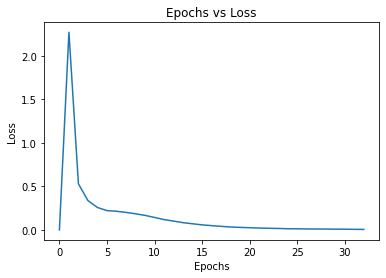

In [ ]:
fig, ax = plt.subplots()
plt.plot(epo_rec,loss_rec)
plt.title('Epochs vs Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.locator_params(axis="x", integer=True)
plt.show()

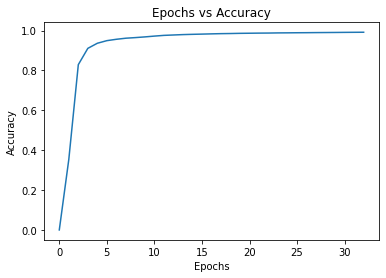

In [ ]:
fig, ax = plt.subplots()
plt.plot(epo_rec,acc_rec)
plt.title('Epochs vs Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.locator_params(axis="x", integer=True)
plt.show()

In [ ]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 98.6%, Avg loss: 0.042781 



#Train-Val Split For ResNet

In [ ]:
type(training_data)

torchvision.datasets.mnist.MNIST

In [ ]:
#80% train 20% val
train_s_data, val_data = torch.utils.data.random_split(training_data, [48000, 12000])

#train_s_data, val_data,_test_data are our respecitve datasets.
#train_s_data to keep it distinct from the training data imported 

In [ ]:
print(len(train_s_data))
print(len(val_data))

48000
12000


In [ ]:
BATCH_SIZE=64

In [ ]:
train_dataloader = DataLoader(train_s_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

#ResNet

We use the version of ResNet that can be loaded from PyTorch via
https://pytorch.org/hub/pytorch_vision_resnet/

In [ ]:
#check what device we're using
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
#https://pytorch.org/vision/stable/models/resnet.html
model = resnet18(pretrained=True).to(device)
#(conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#There's some issues with the base ResNet model by default - it takes inptus of 3 channels instead of 1
#we fix this by doing:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#so that it can take MNIST images
#(fc): Linear(in_features=512, out_features=1000, bias=True)
#the fully connected layer is going to spit out 1000 output features - we only want 10
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
#Layers must be customized BEFORE being sent to GPU. 
#Defining them after sending to GPU will cause errors
#(some layers will be on CPU some will be on GPU)
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
loss_fn = nn.CrossEntropyLoss()
#Opted for regular SGD 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) 

In [ ]:
#Code snippet attribution:
#https://pytorch.org/tutorials/beginner/basics/intro.html
#was used as part of the research process
#Modifications were made so that data could be processed as longs,
#additional statistics could be reported, 
#and a separate validate process was created. 

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    end = math.floor(size/BATCH_SIZE) - 1 #fix slight issue with rounding error not using last item in batch
    #print(size)
    #print(end)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #print(X.size())
        #print(batch)
        #X, y = X.to(device), y.to(device)
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.long()) #loss function requires longs

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current =  batch * len(X)
        #When all batches complete
        if batch % 100 == 0:
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            #return (loss, correct) #"correct" corresponds to accuracy
        if (batch>=end): #on last value of enumerate
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print(f"epoch over - loss: {loss:>7f}")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            return (loss, correct) #"correct" corresponds to accuracy

#validation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

#test - only use when training/validation are over
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#Measure validation, and stop the NN if learning has stopped
#increasing in validation
epochs = 100
bestval = 0
decval = 0

loss_rec = [0]
acc_rec = [0]
epo_rec = [0]
#store loss and accuracy every 10 epochs

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losst, acct = train(train_dataloader, model, loss_fn, optimizer)
    #losst = la_tuple[0]
    #acct = la_tuple[1]
    print("val")
    tempval = validate(val_dataloader, model, loss_fn)
    #if (t+1) % 10 == 0: #change to desired epoch records factor - e.g. t+1 % 10 every 10 epochs
    if 1==1: #test statement
      loss_rec.append(losst)
      acc_rec.append(acct)
      epo_rec.append(t+1)

    if(tempval < bestval):
      decval+=1 
      if(decval==3):
        loss_rec.append(losst)
        acc_rec.append(acct)
        epo_rec.append(t+1)
        print("Validation no longer rising. Done!")
        break
    else:
      bestval=tempval
print("Max number of epochs hit or validation stop reached. Done!")

Epoch 1
-------------------------------
loss: 2.741193  [    0/48000]
Train Error: Accuracy: 16.2%
loss: 0.274059  [ 6400/48000]
Train Error: Accuracy: 90.2%
loss: 0.174424  [12800/48000]
Train Error: Accuracy: 94.3%
loss: 0.183806  [19200/48000]
Train Error: Accuracy: 95.8%
loss: 0.060003  [25600/48000]
Train Error: Accuracy: 96.6%
loss: 0.137117  [32000/48000]
Train Error: Accuracy: 97.3%
loss: 0.050864  [38400/48000]
Train Error: Accuracy: 97.6%
loss: 0.121258  [44800/48000]
Train Error: Accuracy: 98.1%
epoch over - loss: 0.059718
Train Error: Accuracy: 98.1%
val
Val Error: 
 Accuracy: 97.9%, Avg loss: 0.070898 

Epoch 2
-------------------------------
loss: 0.151961  [    0/48000]
Train Error: Accuracy: 98.1%
loss: 0.078171  [ 6400/48000]
Train Error: Accuracy: 98.5%
loss: 0.052783  [12800/48000]
Train Error: Accuracy: 98.7%
loss: 0.116692  [19200/48000]
Train Error: Accuracy: 98.8%
loss: 0.051664  [25600/48000]
Train Error: Accuracy: 99.0%
loss: 0.014623  [32000/48000]
Train Error

#Graph Loss and Review Test Accuracy - ResNet

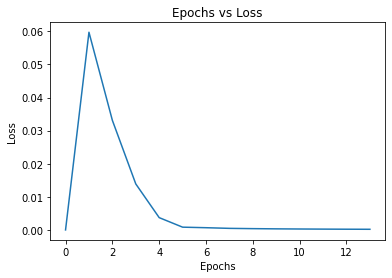

In [ ]:
fig, ax = plt.subplots()
plt.plot(epo_rec,loss_rec)
plt.title('Epochs vs Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.locator_params(axis="x", integer=True)
plt.show()

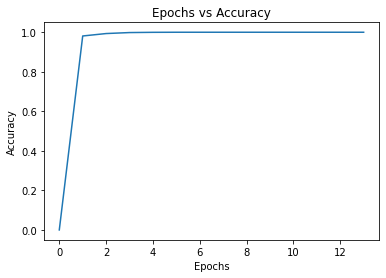

In [ ]:
fig, ax = plt.subplots()
plt.plot(epo_rec,acc_rec)
plt.title('Epochs vs Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.locator_params(axis="x", integer=True)
plt.show()

In [ ]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.057717 



#Outcome and Review

Our convolutional network and the ResNet performed similarly, quickly fitting to the model with over 95% accuracy in under an hour and a half of runtime. The extremely similar test and train accuracies suggest that these are proper fits, as opposed to overfits. 

The benefits of a pretrained model become clear however when we look at the number of epochs each network took to converge on the best possible weights they could learn in this time span - ResNet only took 12 epochs, while our freshly created CNN took 32 epochs. This demonstrates the importance of using pretrained models as it allows us to avoid "reinventing the wheel" and help models solve problems faster by using preexisting models that are likely already capable of solving a problem. 